[org-toggle-latex-overlays> ](org-toggle-latex-overlays> )[org-toggle-pretty-entities](org-toggle-pretty-entities)




# Nonisothermal reactors with reversible reactions



-   The equilibrium conversion is usually the best we can hope for in a reactor for reversible reactions

-   For endothermic reactions, the equilibrium conversion increases with *increasing* temperature
    -   But an adiabatic reactor will decrease in temperature with increasing conversion

-   For an exothermic reaction the equilibrium conversion increases with *decreasing* temperature
    -   But an adiabatic reactor will increase in temperature with increasing conversion

-   Let us illustrate the issues with a simple example

-   Consider $A \leftrightharpoons B$ with $\Delta H_{rx} = -20$ kcal / mol

-   Let the heat capacity of $A$ and $B$ be 50 cal / mol / K

-   The equilibrium constant is 100,000 at 298 K

-   Pure A is fed to an adiabatic CSTR

-   First, we consider the equilibrium conversion that is possible

-   From thermodynamics, and assuming ideal behavior we have

\begin{align}
K = \frac{a_B}{a_A} = \frac{C_B}{C_A}
\end{align}

-   We use fractional conversion to define $C_A$ and $C_B$

\begin{align*}
C_A = C_{A0}(1 - X_{eq}) \\
C_B = C_{A0} X_{eq}
\end{align*}

-   Plugging those into the equilibrium equation and solving for $X_{eq}$ leads to:

\begin{align}
X_{eq} = \frac{K(T)}{1 + K(T)}
\end{align}

-   Where we recall that $K$ is a function of $T$:

\begin{align}
K(T) = K(T_0) \exp \left[\frac{-\Delta H_{rx}(T_0)}{R}\left (\frac{1}{T}-\frac{1}{T_0}\right)\right]
\end{align}

-   Now we can plot the equilibrium conversion as a function of reactor temperature



In [1]:
import numpy as np
import matplotlib.pyplot as plt

Hrx = -20000.0  # cal / mol
R = 1.987
K_298 = 100000.0

T = np.linspace(300, 600)

K = K_298 * np.exp(-Hrx / R * (1.0 / T - 1.0 / 298.0))

Xeq = K / (1.0 + K)

plt.plot(T, Xeq)
plt.xlabel('Temperature (K)')
plt.ylabel('$X_{eq}$')
plt.savefig('images/exo-equil-T.png')

![img](./images/exo-equil-T.png)

-   Not surprisingly, at low temperature  the possibility for nearly complete conversion exists

-   Now, we consider the adiabatic CSTR energy balance

\begin{align}
0 = \sum F_{j0} C_{p,j} (T_{feed} - T) - \Delta H_{rx}(T) r V
\end{align}

-   From the mole balance

\begin{align}
0 = F_{A0} - F_A + \alpha_A r V
\end{align}

-   We find that $r V = (F_A - F_{A0}) / \alpha_A = F_{A0} X$
-   So we have

\begin{align}
X = \frac{C_{p_A}(T_{feed} - T)}{\Delta H_{rx}}
\end{align}

-   Not that if $\Delta H_{rx}$ and $C_{pA}$ do not depend strongly on $T$ this function is linear in $T$
-   Let us consider that function in conjunction with the equilibrium conversion

-   We have to specify a feed temperature, let us consider 300, 400 and 500 K



In [2]:
import numpy as np
import matplotlib.pyplot as plt

Hrx = -20000.0     # J / mol
R = 1.987
K_298 = 100000.0

T = np.linspace(300, 600)

K = K_298 * np.exp(-Hrx / R * (1.0 / T - 1.0 / 298.0))

Xeq = K / (1.0 + K)

plt.plot(T, Xeq, label='$X_{eq}$')

Cpa = 50.0

for Tfeed in [300, 400, 500]:
    X = Cpa*(Tfeed - T) / Hrx
    plt.plot(T, X, label='Tfeed = {0} K'.format(Tfeed))

plt.xlabel('Temperature (K)')
plt.ylabel('$X_{eq}$')
plt.legend(loc='best')
plt.ylim([0, 1])
plt.savefig('images/exo-equil-T-EB.png')

![img](./images/exo-equil-T-EB.png)

-   Clearly you want the lowest feed temperature to get the highest conversion

-   We cannot say yet what the actual conversion will be
    -   It will be on the energy balance line, and less than the equilibrium conversion
    -   The actual conversion depends on the kinetics and feed conditions

-   We will calculate the exit temperature and conversion as a function of feed temperature

-   At a low feed temperature the possible equilibrium conversion may be high, but the kinetics will be slow limiting actual conversion

-   At a high feed temperature the kinetics will be very fast, but the equilibrium conversion will be low

-   This suggests an optimal feed temperature that maximizes the exit conversion

-   We reconsider the example of $A \leftrightharpoons B$ that we considered before.

-   Now, we solve the mole and energy balances simultaneously as a function of feed temperature



not monotonic, have optimal solution
limited by kinetics & thermodynamics

In [5]:
import numpy as np
import matplotlib.pyplot as plt

Hrx = -20000.0     # cal / mol
R = 1.987
K_298 = 100000.0

T_ = np.linspace(300, 600)

K_ = K_298 * np.exp(-Hrx / R * (1.0 / T_ - 1.0 / 298.0))
Xeq = K_ / (1.0 + K_)

plt.plot(T_, Xeq, label='$X_{eq}$')

# mole and energy balances
k1 = 3.1e-6      # Rate constant at 360 K  1 / min
T1 = 360.0       # Reference T for the rate constant
E = 15000.0      # Activation energy

V = 600.0        # reactor volume in L

Cao = 2.0        # initial concentration mol / L
Fao = 10.0       # mol / min
Fbo = 0.0

v0 = Fao / Cao

CpA = 50.0       # heat capacity cal / mol / K
CpB = 50.0
dCp = CpB - CpA  # change in heat capacity due to reaction

def objective(Y, Tfeed):
    X, T = Y  # unpack the variables
    Ca = Cao * (1.0 - X)
    Cb = Cao * X

    k = k1 * np.exp(-E / R * (1.0 / T - 1.0 / T1))
    K = K_298 * np.exp(-Hrx / R * (1.0 / T - 1.0 / 298.0))

    r = k * (Ca - Cb / K)
    ra = -r

    # mole balance
    Fa = Ca * v0
    z1 = (Fao - Fa) + ra * V

    # energy balance
    # Calculate reaction energy at reaction conditions
    Hrxn = Hrx + dCp * (T - Tfeed)
    z2 = (Fao * CpA + Fbo * CpB) * (Tfeed - T) / (-Hrxn * r * V)  + 1
    return [z1, z2]

from scipy.optimize import fsolve

Tfeed = np.linspace(350, 600)
Xe, Te = np.empty(Tfeed.shape), np.empty(Tfeed.shape)

guess = [0.1, 200]
for i, tfeed in enumerate(Tfeed):
    sol, infodict, ier, message = fsolve(objective, guess, args=(tfeed), xtol=1e-6, full_output=1)
    if ier == 1:
        Xe[i], Te[i] = sol
        guess = [Xe[i], Te[i]]
    else:
        print(message)
import matplotlib.pyplot as plt
plt.plot(Tfeed, Xe)

plt.xlabel('Feed temperature')
plt.ylabel('Conversion')
plt.legend(['$X_{eq}$','$X_{exit}$'])

plt.savefig('images/adiabatic-cstr-equilibrium-tfeed-1.png')

![img](./images/adiabatic-cstr-equilibrium-tfeed-1.png)

-   You can see that the optimal feed temperature is at about 470 K with a maximum conversion of 0.1.
    -   Note: this problem is very sensitive to the values of the rate constant.

-   Below that the exit conversion is limited by slow kinetics

-   Above that reaction is limited by the equilibrium conversion

-   As temperature increases the exit conversion approaches the equilibrium conversion

-   To exceed the adiabatic limit you must use a series of reactors with intercooling
    -   The exit of one reactor will be cooled and then feed into the next reactor

-   Let us consider this example

![img](./images/series-cstr-intercooling.png)

-   We will consider a fixed feed temperature of 300 K
-   After the first reactor we cool the stream back to 300 K



In [2]:
import numpy as np

V = 10.0          # m**3
R = 8.314e-3      # gas constant kJ/mol/K

Hrx = -6.900      # Reaction enthalpy kJ/mol at 330 K

k1 = 31.1         # Rate constant at 360 K
T1 = 360.0        # Reference T for the rate constant
E = 65.7          # Activation energy kJ/mol
Kc1 = 3.03        # at 60degC
T2 = 273.15 + 60  # Reference T for the equilibrium constant

Cao = 9300.0      # initial concentration mol / m**3
Fto = 163000.0    # Total molar feed rate mol / hour
Fao = 0.9 * Fto   # inlet molar flow of A
Fbo = 0.0 * Fto
Fio = 0.1 * Fto

v0 = Fao / Cao

CpA = 0.141       # heat capacity kJ / mol / K
CpB = 0.141
dCp = CpB - CpA   # change in heat capacity due to reaction

CpI = 0.161

Tfeed = 300.0 # feed T in K

def objective(Y, Fao):
    X, T = Y  # unpack the variables

    v = v0 * T / Tfeed

    Cao = Fao / v

    Ca = Cao * (1.0 - X)
    Cb = Cao * X

    Fa = Ca * v0

    # Calculate reaction energy at reaction conditions
    Hrxn = Hrx + dCp * (T - Tfeed)

    k = k1 * np.exp(-E / R * (1.0 / T - 1.0 / T1))
    Kc = Kc1 * np.exp(-Hrxn / R * (1.0 / T - 1.0 / T2))

    r = k * (Ca - Cb / Kc)
    ra = -r
    # mole balance
    z1 = Fao - Fa + ra * V

    # energy balance
    z2 = (Fao * CpA
          + Fbo * CpB
          + Fio * CpI) * (Tfeed - T) + (-Hrxn * r * V)
    return [z1, z2]

from scipy.optimize import fsolve

guess = [0.1, 360]

X1, T1 = fsolve(objective, guess, args=(Fao,))

print('After reactor 1: X1 = {0:1.2f} and T1 = {1:1.0f}'.format(X1, T1))

# Now we compute Fa1
Fa1 = Fao * (1.0 - X1)

X2, T2 = fsolve(objective, guess, args=(Fa1,))
print('After reactor 1: X2 = {0:1.2f} and T2 = {1:1.0f}'.format(X2, T2))

After reactor 1: X1 = 0.49 and T1 = 323
After reactor 1: X2 = 0.74 and T2 = 330


-   By using interstage cooling we are able to increase the total conversion
-   An alternative to this is integrating a heat exchanger to keep the reactor isothermal




# Multiple reactions in nonisothermal reactor design



-   The critical point to remember with multiple reactions is we must consider the heat generated from multiple reactions




## Multiple reactions in a nonisothermal CSTR



-   For the CSTR the energy balance is

\begin{equation}
\sum N_i C_{p,i} \frac{dT}{dt} = \sum F_i C_{p,i}(T_0 - T) + \sum (-\Delta H_{rx,j}) r_j V + \dot{Q} + \dot{W}_s
\end{equation}

-   We consider a series reaction $A \rightarrow B \rightarrow C$ in a CSTR

![img](./images/cstr-multi-reactions-heat-exchange.png)

-   It is unclear from the problem setup how many solutions there could be

-   We will use brute force to explore initial guess space and plot a histogram of exit temperatures



/opt/conda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


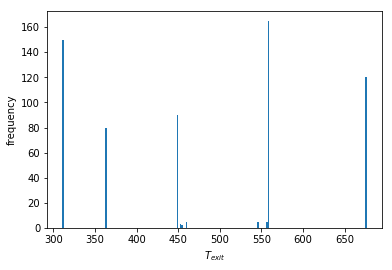

In [5]:
import numpy as np
from scipy.optimize import fsolve

V = 10.0 # Liter

v0 = 1000.0 # L / min
Cafeed = 0.3 # mol / L

# inlet molar flows
Fa0 = v0 * Cafeed
Fb0 = Fc0 = 0.0

# Reaction properties
Hrx1 = -55000.0  # J / mol-A
Hrx2 = -71500.0  # J / mol-B

k1_300 = 3.3     # 1 / min at 300K
E1 = 9900.0      # cal / mol

k2_500 = 4.58    # 1 / min at 500K
E2 = 27000.0     # cal / mol
R = 1.987        # cal / mol / K

# thermal properties
Cpa = Cpb = Cpc = 200.0 # J / mol /K
Tfeed = 283.0 # K

# heat exchanger
Ta = 330.0   # K heat exchanger
Ua = 40000.0 # J / min / K

def objective(Y):
    Fa, Fb, Fc, T = Y
    k1 = k1_300 * np.exp(-E1 / R * (1.0 / T - 1.0 / 300.0))
    k2 = k2_500 * np.exp(-E2 / R * (1.0 / T - 1.0 / 500.0))

    Ca = Fa / v0
    Cb = Fb / v0

    r1 = k1 * Ca
    r2 = k2 * Cb

    # net rates
    ra = -r1
    rb = r1 - r2
    rc = r2

    # mole balances
    z1 = Fa0 - Fa + ra * V
    z2 = Fb0 - Fb + rb * V
    z3 = Fc0 - Fc + rc * V

    # energy balance
    z4 = Ua * (Ta - T) + Fa0 * Cpa * (Tfeed - T) + V * (r1 * -Hrx1 + r2 * -Hrx2)
    return [z1, z2, z3, z4]

solutions = []
for Ca in [0.01, 0.1, 0.2, 0.3, 0.4]:
    for Cb in [0.01, 0.1, 0.2, 0.3, 0.4]:
        for Cc in [0.01, 0.1, 0.2, 0.3, 0.4]:
            for Tg in [300, 400, 500, 600, 700]:
                Yy0 = [v0*Ca, v0*Cb, v0*Cc, Tg]
                sol = fsolve(objective, Yy0)
                Texit = sol[-1]
                solutions += [Texit]

import matplotlib.pyplot as plt
plt.hist(solutions, 200)
plt.xlabel('$T_{exit}$')
plt.ylabel('frequency')
plt.savefig('images/cstr-mult-reactions-mult-steady-states.png')
plt.show()

![img](./images/cstr-mult-reactions-mult-steady-states.png)

-   Our analysis suggests up to five possible steady state solutions

-   Only three of these are likely to be stable solutions

-   If you derive expressions for the heat generated and removed from this reactor you can see why
    -   And that you would expect 5 steady state solutions

-   A final note is that &tau; in this case is equal to 0.01
    -   That is very short!
    -   A larger &tau; would likely result in a single steady state solution




## Multiple reactions in a plug-flow reactor



-   The energy balance for multiple reactions changes only in that we have more species to consider, and we have reaction enthalpies from multiple reactions

-   For the plug flow reactor this leads to

\begin{align}
\frac{dT}{dV} = \frac{\dot{Q} +  \sum (-\Delta H_{rxn,i}(T) r_i) }{\sum F_j C_{p,j}}
\end{align}

-   We consider the parallel reactions

\begin{align*}
A \rightarrow B \\
2A \rightarrow C
\end{align*}

-   The two reactions are both exothermic and have elementary rate laws

-   We consider a PFR with an ambient temperature heat exchanger that will cool the reactor

![img](./images/pfr-multi-heat-exchanger.png)

-   We want to know the temperature profile in the reactor, and the exit molar flow of each species



In [ ]:
import numpy as np
from scipy.integrate import odeint

Fa0 = 100.0             # mol / s
Tfeed = 150.0 + 273.15  # feed temperature
Cafeed = 0.1            # mol / L

Ft0 = Fa0

v0 = Fa0 / Cafeed

# reaction properties
Hrx1 = -20.0  # kJ / mol A
Hrx2 = -60.0  # kJ / mol A

Cpa = 0.090
Cpb = 0.090
Cpc = 0.180

Ua = 4      # kJ / L / s /K
Ta = 373.0  # K

E1R = 4000.0  # K at 300 K
E2R = 9000.0


def pfr(Y, V):
    Fa, Fb, Fc, T = Y
    Ft = Fa + Fb + Fc

    k1a = 10.0 * np.exp(-E1R * (1.0 / T - 1.0 / 300.0))
    k2a = 0.09 * np.exp(-E2R * (1.0 / T - 1.0 / 300.0))

    v = v0 * (Ft / Ft0) * (T / Tfeed)
    Ca = Fa / v

    r1a = -k1a * Ca
    r2a = -k2a * Ca**2

    r1 = -r1a
    r2 = r2a / -2.0

    ra = -r1 - 2 * r2
    rb = r1
    rc = r2

    dFadV = ra
    dFbdV = rb
    dFcdV = rc

    dTdV = ((r1 * -Hrx1   # heat from rxn 1
             + 2 * r2 * -Hrx2  # heat from rxn 2
             + Ua * (Ta - T))  # Qdot
             / (Fa * Cpa + Fb * Cpb + Fc * Cpc))
    return [dFadV, dFbdV, dFcdV, dTdV]

Y0 = [Fa0, 0.0, 0.0, Tfeed]
Vspan = np.linspace(0, 1)
sol = odeint(pfr, Y0, Vspan)

Fa = sol[:, 0]
Fb = sol[:, 1]
Fc = sol[:, 2]
T = sol[:, 3]

import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.plot(Vspan, Fa, Vspan, Fb, Vspan, Fc)
plt.xlabel('Volume (L)')
plt.ylabel('Molar flow (mol/s)')
plt.legend(['Fa', 'Fb', 'Fc'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(Vspan, T)
plt.xlabel('Volume (L)')
plt.ylabel('Temperature (K)')
plt.tight_layout()
plt.savefig('images/pfr-mult-reactions-ua.png')
plt.show()

![img](./images/pfr-mult-reactions-ua.png)

-   Note that we had to use $2 r_2$ in the energy balance because the heat of reaction was defined for that reaction as *per mole of A*

-   You see a very sharp rise in temperature until the reaction is complete

-   After that you see a drop in temperature from the cooling by the heat exchanger

